# Validation

In [267]:
import pandas as pd
import numpy as np
import json
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
import sys
import pickle
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np

# load environment variables
load_dotenv()

#add working directory to sys path to execute utils/dataset.py
working_dir = os.environ.get("WORKING_DIRECTORY")
sys.path.insert(0, working_dir)

from utils.pipeline_moduls import outlier_label, outlier_num


In [268]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils.dataset import get_data 
df = get_data()
df.head(10)

#sample data to 1000 rows
df = df.sample(1000, random_state=42)

Loading data from wines: 8000it [00:00, 12376.35it/s]


In [269]:
#TODO: add load valdiation data from csv
#df = pd.read_csv('./data/validation.csv')

In [270]:
categorical_features = df.select_dtypes(include=['object']).columns
numerical_features = df.select_dtypes(include=[np.number]).columns
#drop 'quality' from numerical features (its a series)
numerical_features = numerical_features.drop('quality')
label = pd.Series('quality')

## Cleaning Pipeline

### Methods

In [271]:
outlier_detection_label = FunctionTransformer(outlier_label).set_output(transform="pandas")
outlier_detection = FunctionTransformer(outlier_num).set_output(transform="pandas")

def feature_selection(df, json_file: str = "./task_2/dropped_features.json"):
    try:
        with open(json_file, 'r') as f:
            dropped_features = json.load(f)
    except FileNotFoundError:
        print(f"File {json_file} not found")
        return None

    # Find common features between DataFrame columns and dropped features
    common_features = list(set(df.columns).intersection(dropped_features))
    if not common_features:
        print("No dropped features found in the DataFrame.")
        return df
    
    # Remove the common features from the DataFrame
    df = df.drop(common_features, axis=1)
    print("Working with following columns:", df.columns.values)
    return df
feature_selection = FunctionTransformer(feature_selection).set_output(transform="pandas")

C:\Users\LucaH\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


#### Sub-Pipeline: Categorical Features

In [272]:
categorical_imputer = SimpleImputer(strategy="most_frequent").set_output(transform="pandas")

#pipeline for categorical features
categorical_pipeline = Pipeline(steps=[])
categorical_pipeline.steps.append(('imputer', categorical_imputer))
categorical_pipeline.steps.append(('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform="pandas")))

#### Sub-Pipeline: Numerical Features

In [273]:
from sklearn.preprocessing import MinMaxScaler
scaler_minmax = MinMaxScaler()

In [274]:
#pipeline for numerical features without scaling
numeric_pipeline = Pipeline(steps=[])
numerical_imputer = SimpleImputer(strategy="mean").set_output(transform="pandas")

numeric_pipeline.steps.append(('imputer', numerical_imputer))
numeric_pipeline.steps.append(('outlier_detection', outlier_detection))


In [275]:
#pipeline for numerical features with scaling
numeric_pipeline_scaled = Pipeline(steps=[])
numerical_imputer = SimpleImputer(strategy="mean").set_output(transform="pandas")

numeric_pipeline_scaled.steps.append(('imputer', numerical_imputer))
numeric_pipeline_scaled.steps.append(('outlier_detection', outlier_detection))
numeric_pipeline_scaled.steps.append(('scaler', scaler_minmax))

#### Sub-Pipeline: Label

In [276]:
#pipeline for label
label_pipeline = Pipeline(steps=[])
label_pipeline.steps.append(('imputer', numerical_imputer))


### Pipeline

In [277]:
cleaning_pipeline = Pipeline(steps=[
])

In [278]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features),
        ('label', label_pipeline, label)
    ]).set_output(transform="pandas")
cleaning_pipeline.steps.append(('preprocessor', preprocessor))
cleaning_pipeline.steps.append(('feature_selection', feature_selection))
cleaning_pipeline.steps.append(('outlier_label', outlier_detection_label))
cleaning_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('outlier_detection',
                                                                   FunctionTransformer(func=<function outlier_num at 0x0000022F44DC9580>))]),
                                                  Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'magnesium', 'flavanoids', 'minerals', 'calcium', 'chlorides',
       'free sulfur dioxi...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['wine type'], dtype='object')),
                                                 ('label',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  0    quality
dtype: object)])),
                ('feature_selection',
                 FunctionTransformer(func=<function feature_selection at 0x0000022F62515300>)),
                ('outlier_label',
                 FunctionTransformer(func=<function outlier_label at 0x0000022F4418A8E0>))])

In [279]:
cleaning_pipeline_scaled = Pipeline(steps=[
])

In [280]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline_scaled, numerical_features),
        ('cat', categorical_pipeline, categorical_features),
        ('label', label_pipeline, label)
    ]).set_output(transform="pandas")
cleaning_pipeline_scaled.steps.append(('preprocessor', preprocessor))
cleaning_pipeline_scaled.steps.append(('feature_selection', feature_selection))
cleaning_pipeline_scaled.steps.append(('outlier_label', outlier_detection_label))
cleaning_pipeline_scaled

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('outlier_detection',
                                                                   FunctionTransformer(func=<function outlier_num at 0x0000022F44DC9580>)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'magnesium', 'flavanoids', 'minerals', 'calcium', 'c...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['wine type'], dtype='object')),
                                                 ('label',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  0    quality
dtype: object)])),
                ('feature_selection',
                 FunctionTransformer(func=<function feature_selection at 0x0000022F62515300>)),
                ('outlier_label',
                 FunctionTransformer(func=<function outlier_label at 0x0000022F4418A8E0>))])

## Validation of our trained models

### KNN
with scaled data

In [281]:
cleaned_data = cleaning_pipeline.fit_transform(df)

#show where label__quality is over 10
cleaned_data

Working with following columns: ['num__fixed acidity' 'num__volatile acidity' 'num__citric acid'
 'num__magnesium' 'num__flavanoids' 'num__chlorides'
 'num__total sulfur dioxide' 'num__density' 'num__pH' 'num__sulphates'
 'num__alcohol' 'cat__wine type_Cabernet Sauvignon'
 'cat__wine type_Chardonnay' 'cat__wine type_Gamay'
 'cat__wine type_Merlot' 'label__quality']


,num__fixed acidity,num__volatile acidity,num__citric acid,num__magnesium,num__flavanoids,num__chlorides,num__total sulfur dioxide,num__density,num__pH,num__sulphates,num__alcohol,cat__wine type_Cabernet Sauvignon,cat__wine type_Chardonnay,cat__wine type_Gamay,cat__wine type_Merlot,label__quality
2215,7.3,0.26,0.32,44.031071,1074.26,0.043,104.0,0.99520,3.24,0.45,10.7,0.0,0.0,0.0,1.0,4.0
2582,7.4,0.20,0.37,44.190938,1013.36,0.028,89.0,0.99132,3.14,0.61,11.8,0.0,0.0,0.0,1.0,6.0
1662,7.8,0.23,0.28,93.440621,1001.49,0.042,166.0,0.99280,2.96,0.40,11.5,1.0,0.0,0.0,0.0,5.0
3027,8.2,0.20,0.36,36.782336,876.51,0.035,163.0,0.99520,3.05,0.30,10.3,0.0,0.0,0.0,0.0,6.0
4343,6.5,0.32,0.12,18.258918,701.89,0.033,165.0,0.99740,3.22,0.32,9.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2948,6.2,0.20,0.26,18.505367,995.15,0.042,161.0,0.99240,3.44,0.66,11.0,0.0,0.0,0.0,0.0,5.0
4195,6.4,0.15,0.25,77.729549,709.78,0.050,68.0,0.99394,3.16,0.40,9.9,1.0,0.0,0.0,0.0,6.0
6885,6.1,0.25,0.48,77.686845,904.74,0.052,94.0,0.99782,3.07,0.45,9.2,0.0,1.0,0.0,0.0,6.0
2764,7.2,0.23,0.39,89.836406,698.22,0.053,106.0,0.99166,3.18,0.47,11.1,0.0,1.0,0.0,0.0,6.0


In [282]:
def run_prediction(df, model_name, scaler=False, dev=False):

    if scaler:
        cleaned_data = cleaning_pipeline_scaled.fit_transform(df)
    else:
        cleaned_data = cleaning_pipeline.fit_transform(df)


    if dev:
        path = './task_2/models/7000_samples/'
    else:
        path = './task_2/models/'

    #load model with pickle
    model = pickle.load(open(f'{path}{model_name}.pkl', 'rb'))
    X = cleaned_data.drop('label__quality', axis=1)
    y = cleaned_data['label__quality']
    print("----------------------------------------")
    print("Accuracy:", model.score(X, y))
    print("----------------------------------------")

    #predict label__quality
    prediction = model.predict(X)

    #make the same but with seaborn
    sns.set_theme(style="whitegrid")
    sns.set(rc={'figure.figsize':(10,5)})
    ax = sns.scatterplot(x=prediction, y=y, s=30)
    ax.plot([0, 10], [0, 10], color='red', linewidth=1)
    ax.set(xlabel='Predicted quality', ylabel='Actual quality', title=model_name)
    ax.set_xticks(np.arange(0, 10, 1))
    ax.set_yticks(np.arange(0, 10, 1))
 


In [283]:
#switch to True if you want to run the prediction on the dev set
dev = True

## 3. Random Forest Regressor
without scaled data

Working with following columns: ['num__fixed acidity' 'num__volatile acidity' 'num__citric acid'
 'num__magnesium' 'num__flavanoids' 'num__chlorides'
 'num__total sulfur dioxide' 'num__density' 'num__pH' 'num__sulphates'
 'num__alcohol' 'cat__wine type_Cabernet Sauvignon'
 'cat__wine type_Chardonnay' 'cat__wine type_Gamay'
 'cat__wine type_Merlot' 'label__quality']
----------------------------------------
Accuracy: 0.852911123497591
----------------------------------------


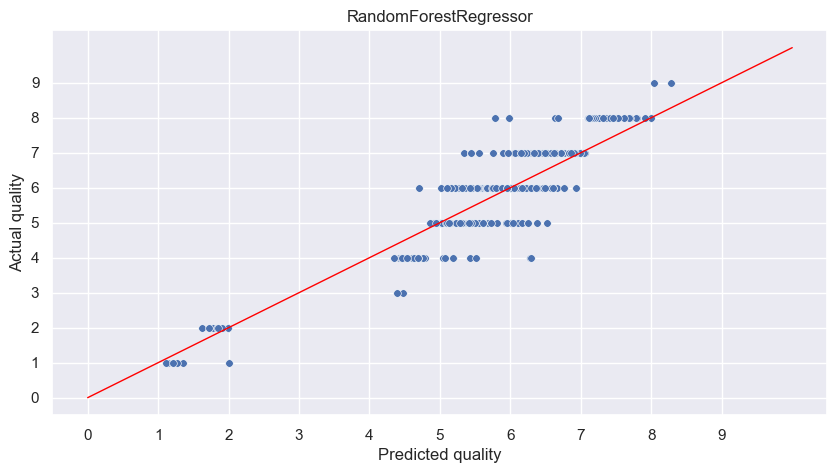

In [284]:
run_prediction(df, 'RandomForestRegressor', scaler=False, dev=dev)

## 2. KNN Regressor
with scaled data

Working with following columns: ['num__fixed acidity' 'num__volatile acidity' 'num__citric acid'
 'num__magnesium' 'num__flavanoids' 'num__chlorides'
 'num__total sulfur dioxide' 'num__density' 'num__pH' 'num__sulphates'
 'num__alcohol' 'cat__wine type_Cabernet Sauvignon'
 'cat__wine type_Chardonnay' 'cat__wine type_Gamay'
 'cat__wine type_Merlot' 'label__quality']
----------------------------------------
Accuracy: 0.6598290878103336
----------------------------------------


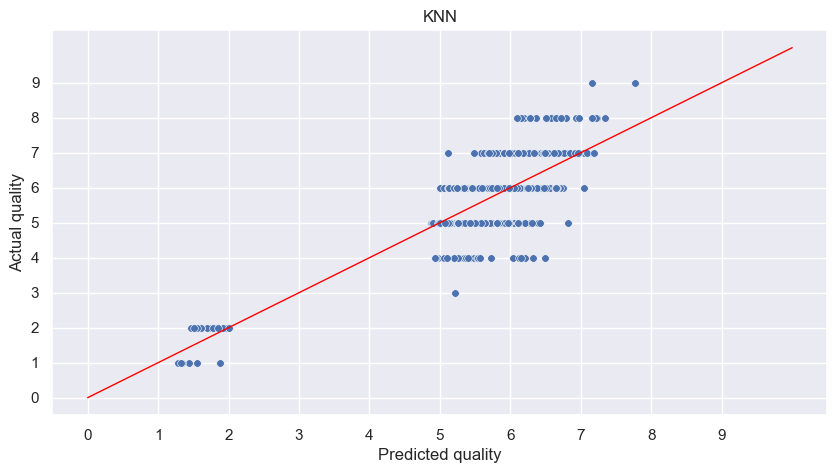

In [285]:
run_prediction(df, 'KNN', scaler=True, dev=dev)

## 1. Gradient Boosting Regressor
without scaled data

Working with following columns: ['num__fixed acidity' 'num__volatile acidity' 'num__citric acid'
 'num__magnesium' 'num__flavanoids' 'num__chlorides'
 'num__total sulfur dioxide' 'num__density' 'num__pH' 'num__sulphates'
 'num__alcohol' 'cat__wine type_Cabernet Sauvignon'
 'cat__wine type_Chardonnay' 'cat__wine type_Gamay'
 'cat__wine type_Merlot' 'label__quality']
----------------------------------------
Accuracy: 0.8974554661666864
----------------------------------------


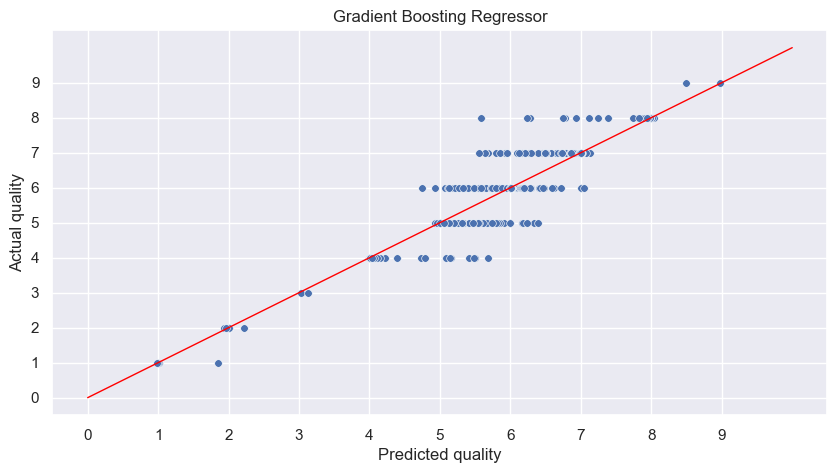

In [286]:
run_prediction(df, 'Gradient Boosting Regressor', scaler=False, dev=dev)

___

## Optional: andere Modelle

### Support Vector Machine Regressor
with scaled data

Working with following columns: ['num__fixed acidity' 'num__volatile acidity' 'num__citric acid'
 'num__magnesium' 'num__flavanoids' 'num__chlorides'
 'num__total sulfur dioxide' 'num__density' 'num__pH' 'num__sulphates'
 'num__alcohol' 'cat__wine type_Cabernet Sauvignon'
 'cat__wine type_Chardonnay' 'cat__wine type_Gamay'
 'cat__wine type_Merlot' 'label__quality']
----------------------------------------
Accuracy: 0.5806280824941833
----------------------------------------


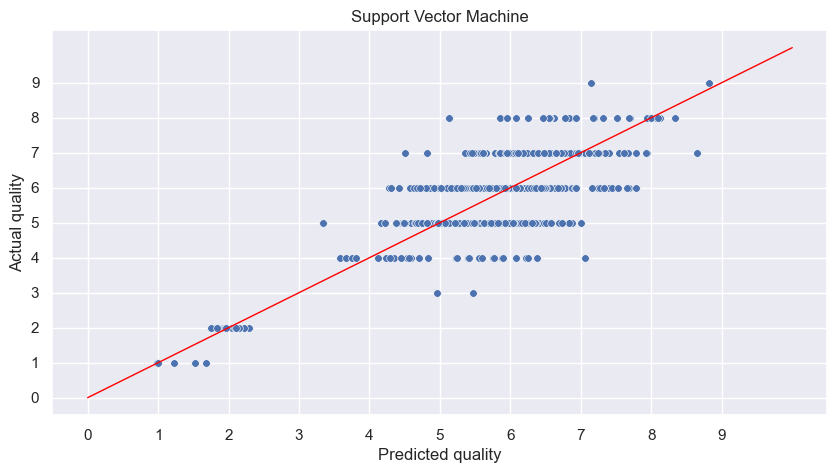

In [287]:
run_prediction(df, 'Support Vector Machine', scaler=True, dev=dev)

### DecisionTreeRegressor
without scaled data

Working with following columns: ['num__fixed acidity' 'num__volatile acidity' 'num__citric acid'
 'num__magnesium' 'num__flavanoids' 'num__chlorides'
 'num__total sulfur dioxide' 'num__density' 'num__pH' 'num__sulphates'
 'num__alcohol' 'cat__wine type_Cabernet Sauvignon'
 'cat__wine type_Chardonnay' 'cat__wine type_Gamay'
 'cat__wine type_Merlot' 'label__quality']
----------------------------------------
Accuracy: 0.763175151229611
----------------------------------------


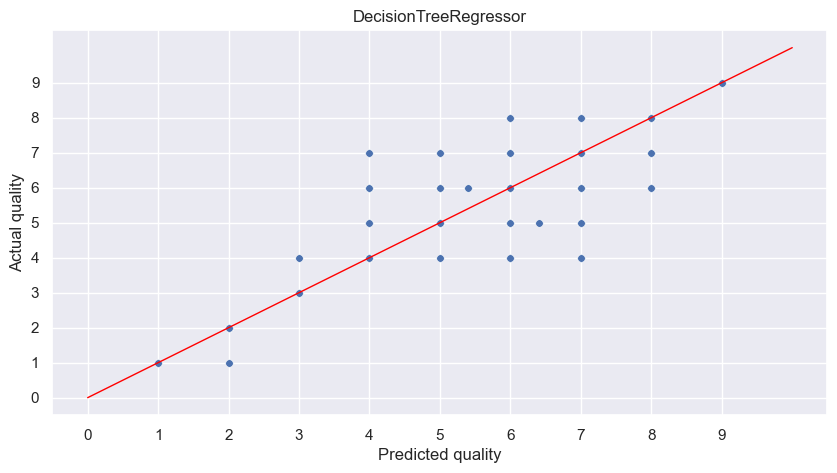

In [288]:
run_prediction(df, 'DecisionTreeRegressor', scaler=False, dev=dev)

### LinearRegression
without scaled data

Working with following columns: ['num__fixed acidity' 'num__volatile acidity' 'num__citric acid'
 'num__magnesium' 'num__flavanoids' 'num__chlorides'
 'num__total sulfur dioxide' 'num__density' 'num__pH' 'num__sulphates'
 'num__alcohol' 'cat__wine type_Cabernet Sauvignon'
 'cat__wine type_Chardonnay' 'cat__wine type_Gamay'
 'cat__wine type_Merlot' 'label__quality']
----------------------------------------
Accuracy: 0.5255911668993836
----------------------------------------


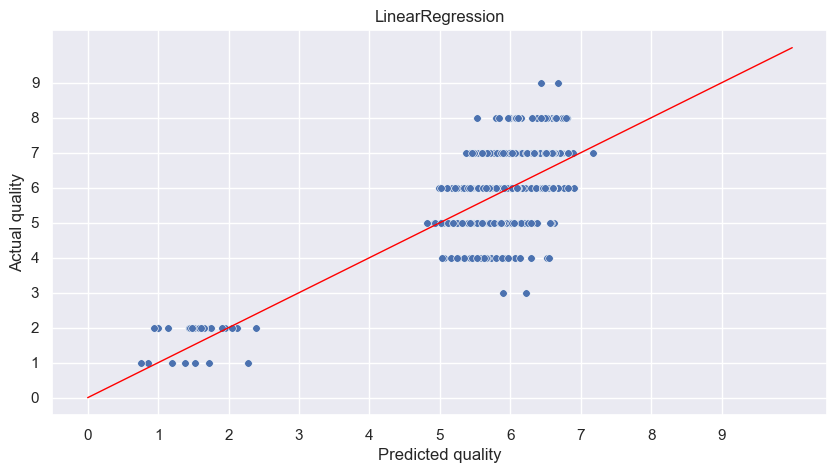

In [289]:
run_prediction(df, 'LinearRegression', scaler=False, dev=dev)